Name: Mrinal Misra

Roll: 121CS0132

In [6]:
!pip install numpy==1.24.4

Defaulting to user installation because normal site-packages is not writeable


In [25]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
# from tensorflow.keras.datassets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD,Adam,Nadam,AdamW
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner import RandomSearch, GridSearch, BayesianOptimization

In [2]:
print(np.__version__)

1.24.4


In [3]:
from tensorflow.keras.datasets import mnist

In [4]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [5]:
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

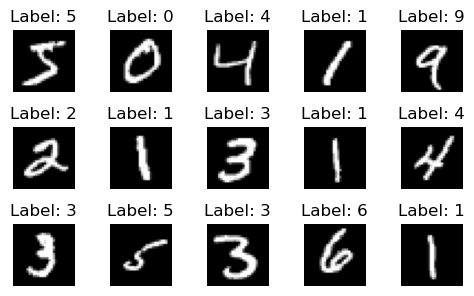

In [6]:
plt.figure(figsize=(5,5))
for i in range(15):
    plt.subplot(5, 5, i+1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(f"Label: {train_labels[i]}")
    plt.axis('off')
    
plt.tight_layout()
plt.show()

In [7]:
X_trn = train_images[:1000]
y_trn = train_labels[:1000]
X_tst = test_images[:500]
y_tst = test_labels[:500]


In [8]:
X_trn.shape,y_trn.shape

((1000, 28, 28), (1000,))

In [9]:
X_trn = X_trn.reshape((X_trn.shape[0], 28 * 28)).astype('float32') / 255
X_tst = X_tst.reshape((X_tst.shape[0], 28 * 28)).astype('float32') / 255


In [54]:
# Number of times to call the model
num_calls = 1
# List to store test accuracies
test_accuracies = []
for i in range(num_calls):
 print("step: ",i+1)
 # Define, compile, and train the model
 
 model = keras.Sequential()
 model.add(Dense(128, activation='sigmoid',input_shape=(784,)))
 model.add(Dropout(0.5))
 model.add(Dense(64, activation='tanh'))
 model.add(Dropout(0.5))
 model.add(Dense(32, activation='tanh'))
 model.add(Dropout(0.5))
 model.add(Dense(16, activation='tanh'))
 model.add(Dropout(0.5))
 model.add(Dense(10, activation='softmax'))
 

 sgd = SGD(learning_rate=0.01) 
 model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
 model.fit(X_trn, y_trn, epochs=5, batch_size=32)
 
 # Evaluate the model on test data
 _, test_accuracy = model.evaluate(X_tst, y_tst,verbose=0)
 
 # Append test accuracy to the list
 test_accuracies.append(test_accuracy)
# Compute the mean of test accuracies
mean_test_accuracy = np.mean(test_accuracies)
print("Mean Test Accuracy:", mean_test_accuracy)


step:  1
Epoch 1/5
32/32 [==============================] - 1s 3ms/step - loss: 2.6412 - accuracy: 0.1000
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 2.6385 - accuracy: 0.0980
Epoch 3/5
32/32 [==============================] - 0s 2ms/step - loss: 2.5544 - accuracy: 0.1180
Epoch 4/5
32/32 [==============================] - 0s 3ms/step - loss: 2.5167 - accuracy: 0.1100
Epoch 5/5
32/32 [==============================] - 0s 3ms/step - loss: 2.5503 - accuracy: 0.1080
Mean Test Accuracy: 0.20999999344348907


Mean Accuracy for Sigmoid and Tanh Layers : 0.20999

In [11]:
def build_model(hp):
 
 hp_neurons = hp.Int('neurons', min_value=32, max_value=512, step=32)
 
 model = keras.Sequential()
 model.add(Dense(units=hp_neurons, activation='sigmoid',input_shape=(784,)))
 model.add(Dropout(0.5))
 model.add(Dense(64, activation='tanh'))
 model.add(Dropout(0.5))
 model.add(Dense(32, activation='tanh'))
 model.add(Dropout(0.5))
 model.add(Dense(16, activation='tanh'))
 model.add(Dropout(0.5))
 model.add(Dense(10, activation='softmax'))
 
 # Tune learning rate and batch size
 hp_learning_rate = hp.Choice('learning_rate', values=[0.1, 0.01, 0.15])
 hp_batch_size = hp.Choice('batch_size', values=[4, 8, 16])
 # Compile the model
 model.compile(optimizer=keras.optimizers.SGD(learning_rate=hp_learning_rate),
 loss='sparse_categorical_crossentropy',
 metrics=['accuracy'])
 
 return model

In [12]:
# Configure the tuner
tuner = RandomSearch(
 build_model,
 objective='val_accuracy',
 max_trials=10,
 executions_per_trial=1,
 directory='keras_tuner_mnists',
 project_name='mnist_hyperparameters'
)

In [13]:
hp_batch_size = tuner.oracle.get_space()['batch_size']
tuner.search(X_trn, y_trn, epochs=15, validation_data=(X_tst, y_tst), batch_size=hp_batch_size)

Trial 10 Complete [00h 00m 11s]
val_accuracy: 0.12200000137090683

Best val_accuracy So Far: 0.6019999980926514
Total elapsed time: 00h 02m 06s


Best accuracy with hyperparameter tuning: 0.601999

In [17]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=20)[0]
best_neurons = best_hps.get('neurons')
best_learning_rate = best_hps.get('learning_rate')
best_batch_size = best_hps.get('batch_size')
print(f"Best number of neurons: {best_neurons}")
print(f"Best learning rate: {best_learning_rate}")
print(f"Best batch size: {best_batch_size}")
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
# Evaluate the best model
loss, accuracy = best_model.evaluate(X_tst, y_tst)
print(f"Test accuracy of the best model: {accuracy}")


Best number of neurons: 64
Best learning rate: 0.1
Best batch size: 30
16/16 [==============================] - 0s 2ms/step - loss: 1.0868 - accuracy: 0.6020
Test accuracy of the best model: 0.6019999980926514


In [18]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                50240     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 16)                5

Model-1: 4 hidden layers having 128, 64, 32, 16 number of neurons 
respectively with activation function sigmoid, tanh, relu and selu respectively 
and dropout rate set to 0.5, 0.4, 0.3, 0.1 respectively. Use optimizer as SGD
with batch size set to 32.

In [57]:
# Number of times to call the model
num_calls = 10
# List to store test accuracies
test_accuracies = []
for i in range(num_calls):
 print("step: ",i+1)
 # Define, compile, and train the model
 
 model = keras.Sequential()
 model.add(Dense(128, activation='sigmoid',input_shape=(784,)))
 model.add(Dropout(0.5))
 model.add(Dense(64, activation='tanh'))
 model.add(Dropout(0.4))
 model.add(Dense(32, activation='relu'))
 model.add(Dropout(0.3))
 model.add(Dense(16, activation='selu'))
 model.add(Dropout(0.1))

 sgd = SGD(learning_rate=0.01) 
 model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
 model.fit(X_trn, y_trn, epochs=30, batch_size=32)
 
 # Evaluate the model on test data
 _, test_accuracy = model.evaluate(X_tst, y_tst,verbose=0)
 
 # Append test accuracy to the list
 test_accuracies.append(test_accuracy)
# Compute the mean of test accuracies
mean_test_accuracy = np.mean(test_accuracies)
print("Mean Test Accuracy:", mean_test_accuracy)


step:  1
Epoch 1/30
32/32 [==============================] - 1s 3ms/step - loss: 8.8968 - accuracy: 0.0950
Epoch 2/30
32/32 [==============================] - 0s 2ms/step - loss: 5.7539 - accuracy: 0.0850
Epoch 3/30
32/32 [==============================] - 0s 2ms/step - loss: 5.2613 - accuracy: 0.1120
Epoch 4/30
32/32 [==============================] - 0s 3ms/step - loss: 4.3296 - accuracy: 0.1000
Epoch 5/30
32/32 [==============================] - 0s 2ms/step - loss: 4.4769 - accuracy: 0.0920
Epoch 6/30
32/32 [==============================] - 0s 3ms/step - loss: 4.0468 - accuracy: 0.1080
Epoch 7/30
32/32 [==============================] - 0s 3ms/step - loss: 4.0153 - accuracy: 0.1150
Epoch 8/30
32/32 [==============================] - 0s 3ms/step - loss: 3.8591 - accuracy: 0.1170
Epoch 9/30
32/32 [==============================] - 0s 2ms/step - loss: 3.7724 - accuracy: 0.1130
Epoch 10/30
32/32 [==============================] - 0s 3ms/step - loss: 3.8521 - accuracy: 0.1160
Epoch 11/3

Mean test Accuracy for Model 1 is 0.1018

Model-2: 4 hidden layers having 128, 64, 32, 16 number of neurons 
respectively with activation function sigmoid, tanh, relu and selu respectively 
and dropout rate set to 0.5, 0.4, 0.3, 0.1 respectively. Use optimizer as Adam
with batch size set to 32

In [21]:
# Number of times to call the model
num_calls = 10
# List to store test accuracies
test_accuracies = []
for i in range(num_calls):
 print("step: ",i+1)
 # Define, compile, and train the model
 
 model = keras.Sequential()
 model.add(Dense(128, activation='sigmoid',input_shape=(784,)))
 model.add(Dropout(0.5))
 model.add(Dense(64, activation='tanh'))
 model.add(Dropout(0.4))
 model.add(Dense(32, activation='relu'))
 model.add(Dropout(0.3))
 model.add(Dense(16, activation='selu'))
 model.add(Dropout(0.1))
 model.add(Dense(10, activation='softmax'))
 

 sgd = Adam(learning_rate=0.01) 
 model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
 model.fit(X_trn, y_trn, epochs=30, batch_size=32)
 
 # Evaluate the model on test data
 _, test_accuracy = model.evaluate(X_tst, y_tst,verbose=0)
 
 # Append test accuracy to the list
 test_accuracies.append(test_accuracy)
# Compute the mean of test accuracies
mean_test_accuracy = np.mean(test_accuracies)
print("Mean Test Accuracy:", mean_test_accuracy)


step:  1
Epoch 1/30
32/32 [==============================] - 1s 4ms/step - loss: 9.7610 - accuracy: 0.0850
Epoch 2/30
32/32 [==============================] - 0s 3ms/step - loss: 2.9387 - accuracy: 0.0710
Epoch 3/30
32/32 [==============================] - 0s 3ms/step - loss: 2.8079 - accuracy: 0.0900
Epoch 4/30
32/32 [==============================] - 0s 3ms/step - loss: 2.8139 - accuracy: 0.0790
Epoch 5/30
32/32 [==============================] - 0s 3ms/step - loss: 2.7910 - accuracy: 0.0720
Epoch 6/30
32/32 [==============================] - 0s 3ms/step - loss: 2.8261 - accuracy: 0.0900
Epoch 7/30
32/32 [==============================] - 0s 3ms/step - loss: 2.8608 - accuracy: 0.0990
Epoch 8/30
32/32 [==============================] - 0s 3ms/step - loss: 2.8220 - accuracy: 0.0890
Epoch 9/30
32/32 [==============================] - 0s 3ms/step - loss: 2.7833 - accuracy: 0.0880
Epoch 10/30
32/32 [==============================] - 0s 3ms/step - loss: 2.7804 - accuracy: 0.0790
Epoch 11/3

Mean Test Accurcy for Model 2: 0.073

Model-3: 4 hidden layers having 128, 64, 32, 16 number of neurons 
respectively with activation function sigmoid, tanh, relu and selu respectively 
and dropout rate set to 0.5, 0.4, 0.3, 0.1 respectively

In [26]:
# Number of times to call the model
num_calls = 10
# List to store test accuracies
test_accuracies = []
for i in range(num_calls):
 print("step: ",i+1)
 # Define, compile, and train the model
 
 model = keras.Sequential()
 model.add(Dense(128, activation='sigmoid',input_shape=(784,)))
 model.add(Dropout(0.5))
 model.add(Dense(64, activation='tanh'))
 model.add(Dropout(0.4))
 model.add(Dense(32, activation='relu'))
 model.add(Dropout(0.3))
 model.add(Dense(16, activation='selu'))
 model.add(Dropout(0.1))
 model.add(Dense(10, activation='softmax'))
 
 sgd = AdamW(learning_rate=0.1) 
 model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
 model.fit(X_trn, y_trn, epochs=30, batch_size=32)
 
 # Evaluate the model on test data
 _, test_accuracy = model.evaluate(X_tst, y_tst,verbose=0)
 
 # Append test accuracy to the list
 test_accuracies.append(test_accuracy)
# Compute the mean of test accuracies
mean_test_accuracy = np.mean(test_accuracies)
print("Mean Test Accuracy:", mean_test_accuracy)


step:  1
Epoch 1/30
32/32 [==============================] - 1s 4ms/step - loss: 3.6568 - accuracy: 0.0890
Epoch 2/30
32/32 [==============================] - 0s 3ms/step - loss: 2.8488 - accuracy: 0.0920
Epoch 3/30
32/32 [==============================] - 0s 3ms/step - loss: 2.8872 - accuracy: 0.1020
Epoch 4/30
32/32 [==============================] - 0s 3ms/step - loss: 2.8605 - accuracy: 0.0850
Epoch 5/30
32/32 [==============================] - 0s 3ms/step - loss: 2.8100 - accuracy: 0.0740
Epoch 6/30
32/32 [==============================] - 0s 3ms/step - loss: 2.7993 - accuracy: 0.0840
Epoch 7/30
32/32 [==============================] - 0s 3ms/step - loss: 2.7726 - accuracy: 0.0850
Epoch 8/30
32/32 [==============================] - 0s 3ms/step - loss: 2.7866 - accuracy: 0.0980
Epoch 9/30
32/32 [==============================] - 0s 3ms/step - loss: 2.7859 - accuracy: 0.0930
Epoch 10/30
32/32 [==============================] - 0s 3ms/step - loss: 2.8133 - accuracy: 0.0880
Epoch 11/3

Mean Test Accuracy for Model 3: 0.0834

Model-4: 4 hidden layers having 128, 64, 32, 16 number of neurons 
respectively with activation function sigmoid, tanh, relu and selu respectively 
and dropout rate set to 0.5, 0.4, 0.3, 0.1 respectively. Use optimizer as Nadam
with learning rate 0.1 with batch size set to 32

In [27]:
# Number of times to call the model
num_calls = 10
# List to store test accuracies
test_accuracies = []
for i in range(num_calls):
 print("step: ",i+1)
 # Define, compile, and train the model
 
 model = keras.Sequential()
 model.add(Dense(128, activation='sigmoid',input_shape=(784,)))
 model.add(Dropout(0.5))
 model.add(Dense(64, activation='tanh'))
 model.add(Dropout(0.4))
 model.add(Dense(32, activation='relu'))
 model.add(Dropout(0.3))
 model.add(Dense(16, activation='selu'))
 model.add(Dropout(0.1))
 model.add(Dense(10, activation='softmax'))
 
 sgd = Nadam(learning_rate=0.1) 
 model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
 model.fit(X_trn, y_trn, epochs=30, batch_size=32)
 
 # Evaluate the model on test data
 _, test_accuracy = model.evaluate(X_tst, y_tst,verbose=0)
 
 # Append test accuracy to the list
 test_accuracies.append(test_accuracy)
# Compute the mean of test accuracies
mean_test_accuracy = np.mean(test_accuracies)
print("Mean Test Accuracy:", mean_test_accuracy)


step:  1
Epoch 1/30
32/32 [==============================] - 2s 4ms/step - loss: 7.8151 - accuracy: 0.0920
Epoch 2/30
32/32 [==============================] - 0s 3ms/step - loss: 2.8784 - accuracy: 0.0900
Epoch 3/30
32/32 [==============================] - 0s 3ms/step - loss: 2.7698 - accuracy: 0.0660
Epoch 4/30
32/32 [==============================] - 0s 4ms/step - loss: 2.7859 - accuracy: 0.0860
Epoch 5/30
32/32 [==============================] - 0s 3ms/step - loss: 2.7726 - accuracy: 0.0650
Epoch 6/30
32/32 [==============================] - 0s 3ms/step - loss: 2.7993 - accuracy: 0.0670
Epoch 7/30
32/32 [==============================] - 0s 4ms/step - loss: 2.7985 - accuracy: 0.0730
Epoch 8/30
32/32 [==============================] - 0s 4ms/step - loss: 2.7859 - accuracy: 0.0840
Epoch 9/30
32/32 [==============================] - 0s 3ms/step - loss: 2.7726 - accuracy: 0.0890
Epoch 10/30
32/32 [==============================] - 0s 3ms/step - loss: 2.7726 - accuracy: 0.0780
Epoch 11/3

Mean Test Accuracy for Model 4: 0.0834

2. Tune the hyperparameters using kerastuner to select the best learning rate among the 
set {0.1, 0.01, 0.15} with batch size varying between {4,8,16} and first hidden layer 
neurons varying between 250 to 260 with a step value of 2. 2nd, 3rd and 4th hidden 
layer contains 16, 8, 4 numbers of neurons respectively. The four layers have 
activation function sigmoid, tanh, relu and selu respectively. Use optimizer as SGD 
and find the best hyperparameters to predict the MNIST test data

In [51]:
def build_model(hp):
 
 hp_neurons = hp.Int('neurons', min_value=250, max_value=260, step=2)
 
 model = keras.Sequential()
 model.add(Dense(units=hp_neurons, activation='sigmoid',input_shape=(784,)))
 model.add(Dropout(0.5))
 model.add(Dense(16, activation='tanh'))
 model.add(Dropout(0.5))
 model.add(Dense(8, activation='relu'))
 model.add(Dropout(0.5))
 model.add(Dense(4, activation='selu'))
 model.add(Dropout(0.5))
 model.add(Dense(10, activation='softmax'))
 
 # Tune learning rate and batch size
 hp_learning_rate = hp.Choice('learning_rate', values=[0.1, 0.01, 0.15])
 hp_batch_size = hp.Choice('batch_size', values=[4, 8, 16])
 # Compile the model
 model.compile(optimizer=keras.optimizers.SGD(learning_rate=hp_learning_rate),
 loss='sparse_categorical_crossentropy',
 metrics=['accuracy'])
 
 return model

In [52]:
# Configure the tuner
tuner = RandomSearch(
 build_model,
 objective='val_accuracy',
 max_trials=10,
 executions_per_trial=4,
 directory='keras_tuner_b',
 project_name='mnist_hyperparameters'
)

In [53]:
hp_batch_size = tuner.oracle.get_space()['batch_size']
tuner.search(X_trn, y_trn, epochs=15, validation_data=(X_tst, y_tst), batch_size=hp_batch_size)

Trial 10 Complete [00h 00m 46s]
val_accuracy: 0.1340000033378601

Best val_accuracy So Far: 0.1340000033378601
Total elapsed time: 00h 07m 42s


In [55]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=20)[0]
best_neurons = best_hps.get('neurons')
best_learning_rate = best_hps.get('learning_rate')
best_batch_size = best_hps.get('batch_size')
print(f"Best number of neurons: {best_neurons}")
print(f"Best learning rate: {best_learning_rate}")
print(f"Best batch size: {best_batch_size}")
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
# Evaluate the best model
loss, accuracy = best_model.evaluate(X_tst, y_tst)
print(f"Test accuracy of the best model: {accuracy}")


Best number of neurons: 256
Best learning rate: 0.15
Best batch size: 16
16/16 [==============================] - 0s 3ms/step - loss: 2.3004 - accuracy: 0.1340
Test accuracy of the best model: 0.1340000033378601


Best Accuracy with hyperparameter tuning : 0.134

In [56]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               200960    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 16)                4112      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 4)                 3

Observations: 

Mean test Accuracy for Model 1 is 0.1018

Mean Test Accurcy for Model 2: 0.073

Mean Test Accuracy for Model 3: 0.0834

Mean Test Accuracy for Model 4: 0.0834

Best Accuracy with hyperparameter tuning : 0.134

Hence Hyperparameter tuning shows the highest accuracy among all the methods listed above
